In [1]:
import matplotlib.pyplot as plt

from calibration.calibration import *

Set the variables for the experiment:

- experiment_name = name of the calibration experiment, used for naming the result.
- model_name = name of the model used for the recommendations, used for naming the results. IMPORTANT: this notebook does not generate recommendations, this must be generated using Elliot and passed through reco_file.
- top_k = quantity of recommendations, is important to note that from Elliot, is recommended to do a top_k of all the users in the dataset, because the calibration needs all the scores, if the top_k of Elliot and this notebook match, the calibration will not have effect.
- lmbda = Amount of calibration to apply. Must be between 0 and 1 inclusive. Closer to 1 means more.
- xxx_file = List that includes in the first element a string indicating the data type (only tsv and csv are supported for now), and the second element contains the path to the file.

For files, from Elliot, it is required to generate recommendations AND the split (only the train is required, but Elliot generates both). For more information, check Elliot documentation.

The attribute file MUST be provided, this should be part of the dataset used. For example, movielens comes with the ratings and an acompanying dataset containing the genres for each movie. It should have the columns itemid, title and attribute. The dataset must not have columns, they will be generated inside the module,  same goes for the other 2 datasets.

In [2]:
experiment_name = 'movielens-1m'
model_name = 'wrmf-implicit'
top_k = 50
lmbda = 0.99

# attr_file = ['csv', './data/movielens-1m/movies.csv']
# train_file = ['tsv', './data/movielens-1m/mf/split/0/train.tsv']
# reco_file = ['tsv', './data/movielens-1m/mf/recs/MF_seed=42_e=10_bs=512_factors=10_lr=0$001_reg=0$1_it=10.tsv']

In [3]:
load_path = './results/'
prefix = experiment_name + '_' + model_name + '_' + str(top_k) + '_' + str(lmbda) + '_'

In [4]:
distr_dict = {
    'inter_distr': pd.read_csv(load_path + prefix + 'inter_distr.csv', index_col=0).to_dict(orient='index'),
    'recom_distr': pd.read_csv(load_path + prefix + 'recom_distr.csv', index_col=0).to_dict(orient='index'),
    'calib_distr': pd.read_csv(load_path + prefix + 'calib_distr.csv', index_col=0).to_dict(orient='index')
}

In [5]:
worst_case = np.load(load_path + prefix + 'worst_case.npy')

In [6]:
average_table = {
            'inter_distr': {},
            'recom_distr': {},
            'calib_distr': {},
            'neg_pre_delta': {},
            'pos_pre_delta': {},
            'neg_post_delta': {},
            'pos_post_delta': {},
        }

qty_table = {
    'inter_distr': {},
    'recom_distr': {},
    'calib_distr': {},
    'neg_pre_delta': {},
    'pos_pre_delta': {},
    'neg_post_delta': {},
    'pos_post_delta': {},
}

for user_id in worst_case:
    user_vals = {}

    for kind in set(distr_dict):
        kind_distr = distr_dict[kind][user_id]

        user_vals[kind] = {}

        for attr in set(kind_distr):
            accu_val = average_table[kind].get(attr, 0)
            average_table[kind][attr] = accu_val + kind_distr[attr]

            qty_val = qty_table[kind].get(attr, 0)
            qty_table[kind][attr] = qty_val + 1

            user_vals[kind][attr] = kind_distr[attr]

    for attr in set(user_vals['inter_distr']) | set(user_vals['recom_distr']):
            delta = user_vals['recom_distr'].get(
                attr, 0) - user_vals['inter_distr'].get(attr, 0)
            if delta < 0:
                accu_delta = average_table['neg_pre_delta'].get(attr, 0)
                average_table['neg_pre_delta'][attr] = accu_delta + delta

                qty_val = qty_table['neg_pre_delta'].get(attr, 0)
                qty_table['neg_pre_delta'][attr] = qty_val + 1
            else:
                accu_delta = average_table['pos_pre_delta'].get(attr, 0)
                average_table['pos_pre_delta'][attr] = accu_delta + delta

                qty_val = qty_table['pos_pre_delta'].get(attr, 0)
                qty_table['pos_pre_delta'][attr] = qty_val + 1
    
    for attr in set(user_vals['inter_distr']) | set(user_vals['calib_distr']):
            delta = user_vals['calib_distr'].get(
                attr, 0) - user_vals['inter_distr'].get(attr, 0)
            if delta < 0:
                accu_delta = average_table['neg_post_delta'].get(attr, 0)
                average_table['neg_post_delta'][attr] = accu_delta + delta

                qty_val = qty_table['neg_post_delta'].get(attr, 0)
                qty_table['neg_post_delta'][attr] = qty_val + 1
            else:
                accu_delta = average_table['pos_post_delta'].get(attr, 0)
                average_table['pos_post_delta'][attr] = accu_delta + delta

                qty_val = qty_table['pos_post_delta'].get(attr, 0)
                qty_table['pos_post_delta'][attr] = qty_val + 1

In [7]:
final_averaged_table = (pd.DataFrame(average_table).sort_index() / pd.DataFrame(qty_table).sort_index()).sort_index()
final_averaged_table

,inter_distr,recom_distr,calib_distr,neg_pre_delta,pos_pre_delta,neg_post_delta,pos_post_delta
Action,0.070899,0.055855,0.067972,-0.048688,0.124997,-0.009168,0.010568
Adventure,0.036705,0.019593,0.034882,-0.028771,0.028019,-0.004656,0.002915
Animation,0.013607,0.028724,0.013790,-0.011748,0.050901,-0.003253,0.002677
Children's,0.025406,0.037425,0.025911,-0.016814,0.064188,-0.003833,0.004205
Comedy,0.186810,0.170783,0.186129,-0.109096,0.191510,-0.012477,0.016253
Crime,0.030176,0.021364,0.029230,-0.027009,0.022500,-0.004617,0.002823
Documentary,0.015483,0.010944,0.015430,-0.036997,0.014056,-0.004986,0.001422
Drama,0.238821,0.359103,0.250756,-0.101398,0.241044,-0.009068,0.019697
Fantasy,0.013378,0.004911,0.011974,-0.016469,0.006767,-0.004592,0.001352
Film-Noir,0.013258,0.011278,0.012588,-0.016574,0.015953,-0.005354,0.001497


In [8]:
final_averaged_table.sum()

inter_distr       1.000000
recom_distr       1.000000
calib_distr       1.000000
neg_pre_delta    -0.680719
pos_pre_delta     1.023471
neg_post_delta   -0.103450
pos_post_delta    0.091880
dtype: float64

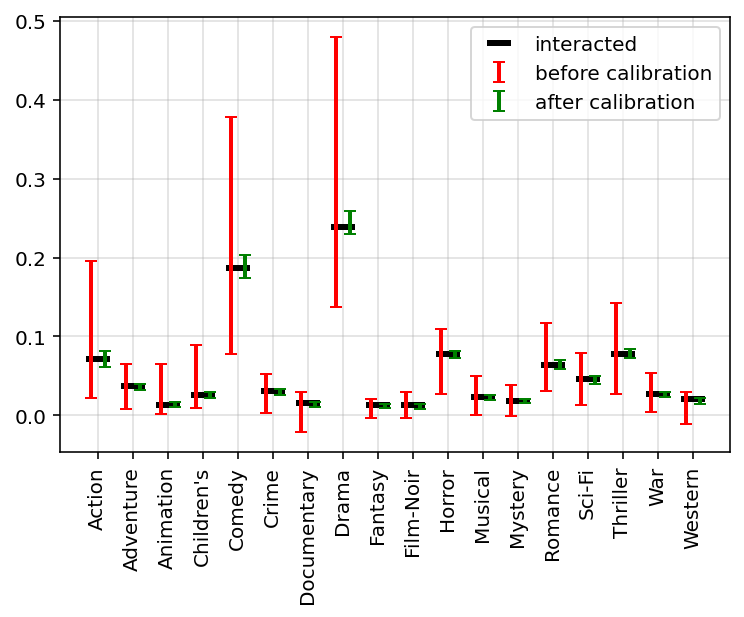

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

info_table_final = final_averaged_table.fillna(0)

info_table_final = info_table_final.sort_index()

n = info_table_final.shape[0]
index = np.arange(n)

plt.plot(index, info_table_final['inter_distr'], '_',
    ms=12.0, mew=3.0, mec='k', label='interacted')

pre_yerr = [
    -np.array(info_table_final['neg_pre_delta'].to_list()),
    np.array(info_table_final['pos_pre_delta'].to_list())
]
post_yerr = [
    -np.array(info_table_final['neg_post_delta'].to_list()),
    np.array(info_table_final['pos_post_delta'].to_list())
]

plt.errorbar(index - 0.2, info_table_final['inter_distr'], yerr=pre_yerr,
    fmt=' ', lw=2, capsize=3, label='before calibration', ecolor='r')
plt.errorbar(index + 0.2, info_table_final['inter_distr'], yerr=post_yerr,
    fmt=' ', lw=2, capsize=3, label='after calibration', ecolor='g')

plt.legend()

plt.xticks(index, info_table_final.index, rotation=90)
plt.grid(alpha=0.4)

plt.savefig(load_path + prefix + 'average_table.png', bbox_inches='tight', dpi=300)
plt.savefig(load_path + prefix + 'average_table.pdf', bbox_inches='tight')
plt.show()

In [10]:
info_table_final.sort_index().fillna(0)

,inter_distr,recom_distr,calib_distr,neg_pre_delta,pos_pre_delta,neg_post_delta,pos_post_delta
Action,0.070899,0.055855,0.067972,-0.048688,0.124997,-0.009168,0.010568
Adventure,0.036705,0.019593,0.034882,-0.028771,0.028019,-0.004656,0.002915
Animation,0.013607,0.028724,0.013790,-0.011748,0.050901,-0.003253,0.002677
Children's,0.025406,0.037425,0.025911,-0.016814,0.064188,-0.003833,0.004205
Comedy,0.186810,0.170783,0.186129,-0.109096,0.191510,-0.012477,0.016253
Crime,0.030176,0.021364,0.029230,-0.027009,0.022500,-0.004617,0.002823
Documentary,0.015483,0.010944,0.015430,-0.036997,0.014056,-0.004986,0.001422
Drama,0.238821,0.359103,0.250756,-0.101398,0.241044,-0.009068,0.019697
Fantasy,0.013378,0.004911,0.011974,-0.016469,0.006767,-0.004592,0.001352
Film-Noir,0.013258,0.011278,0.012588,-0.016574,0.015953,-0.005354,0.001497


In [11]:
info_table_final.sort_index().fillna(0).to_csv(
    load_path + prefix + 'average_table.csv'
)

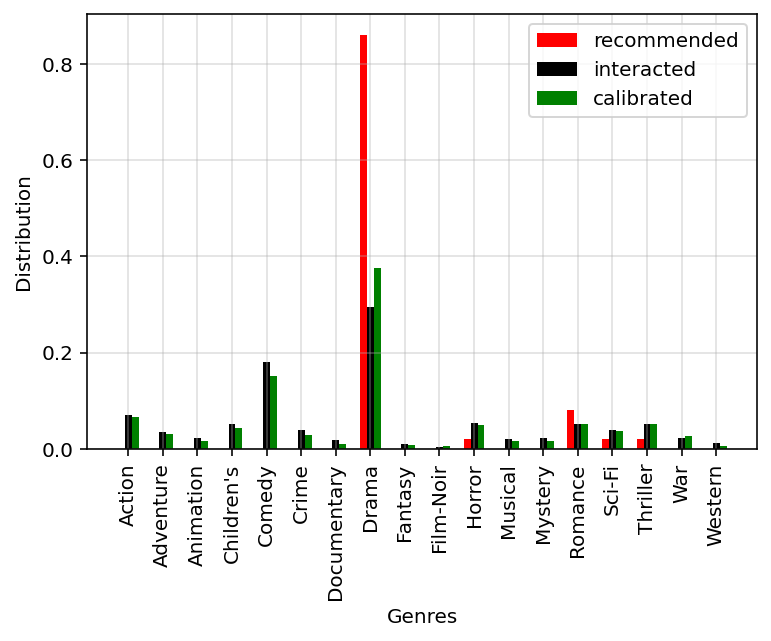

In [12]:
user_id = worst_case[0]

df = pd.DataFrame({
    'recommended': distr_dict['recom_distr'][user_id],
    'interacted': distr_dict['inter_distr'][user_id],
    'calibrated': distr_dict['calib_distr'][user_id]
})

n = df.shape[0]
index = np.arange(n)

plt.bar(index - 0.2, df['recommended'], width=0.2, label='recommended', color='r')
plt.bar(index, df['interacted'], width=0.2, label='interacted', color='k')
plt.bar(index + 0.2, df['calibrated'], width=0.2, label='calibrated', color='g')

plt.xticks(index, df.index, rotation=90)
plt.legend()
plt.grid(True, alpha=0.4)

plt.xlabel('Genres')
plt.ylabel('Distribution')

plt.savefig(load_path + prefix + 'single_table.png', bbox_inches='tight', dpi=300)
plt.savefig(load_path + prefix + 'single_table.pdf', bbox_inches='tight')
plt.show()

In [13]:
df['pre_delta'] = df['recommended'] - df['interacted']
df['post_delta'] = df['calibrated'] - df['interacted']
df['recom_delta'] = df['calibrated'] - df['recommended']

df.sort_index().fillna(0)

,recommended,interacted,calibrated,pre_delta,post_delta,recom_delta
Action,0.00,0.070059,0.065667,-0.070059,-0.004393,0.065667
Adventure,0.00,0.036005,0.031333,-0.036005,-0.004672,0.031333
Animation,0.00,0.022095,0.017333,-0.022095,-0.004762,0.017333
Children's,0.00,0.051145,0.044000,-0.051145,-0.007145,0.044000
Comedy,0.00,0.179856,0.152333,-0.179856,-0.027522,0.152333
Crime,0.00,0.039016,0.028333,-0.039016,-0.010683,0.028333
Documentary,0.00,0.019084,0.010000,-0.019084,-0.009084,0.010000
Drama,0.86,0.295038,0.376667,0.564962,0.081628,-0.483333
Fantasy,0.00,0.010178,0.009000,-0.010178,-0.001178,0.009000
Film-Noir,0.00,0.003605,0.006667,-0.003605,0.003062,0.006667


In [14]:
df.sort_index().fillna(0).to_csv(
    load_path + prefix + 'single_table.csv'
)